<a href="https://colab.research.google.com/github/IAT-ExploringAI-2024/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#run it once for making directories

os.makedirs('/content/drive/MyDrive/cvproject/Final_data')
os.makedirs('/content/drive/MyDrive/cvproject/Final_data/images')
os.makedirs('/content/drive/MyDrive/cvproject/Final_data/labels')
os.makedirs('/content/drive/MyDrive/cvproject/Final_data/images/train')
os.makedirs('/content/drive/MyDrive/cvproject/Final_data/images/val')
os.makedirs('/content/drive/MyDrive/cvproject/Final_data/labels/train')
os.makedirs('/content/drive/MyDrive/cvproject/Final_data/labels/val')

In [4]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.1/112.6 GB disk)


In [5]:
from ultralytics import YOLO

## Training YOLO

Copied images — train: 370, val: 33
Filtered labels — train kept: 340/367, val kept: 32/33 (empty files mean no bikelane in that image)
✅ Wrote /content/drive/MyDrive/cvproject/Final_data_bikelane_only/data_bikelane_only.yaml
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/cvproject/Final_data_bikelane_only/data_bikelane_only.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None,

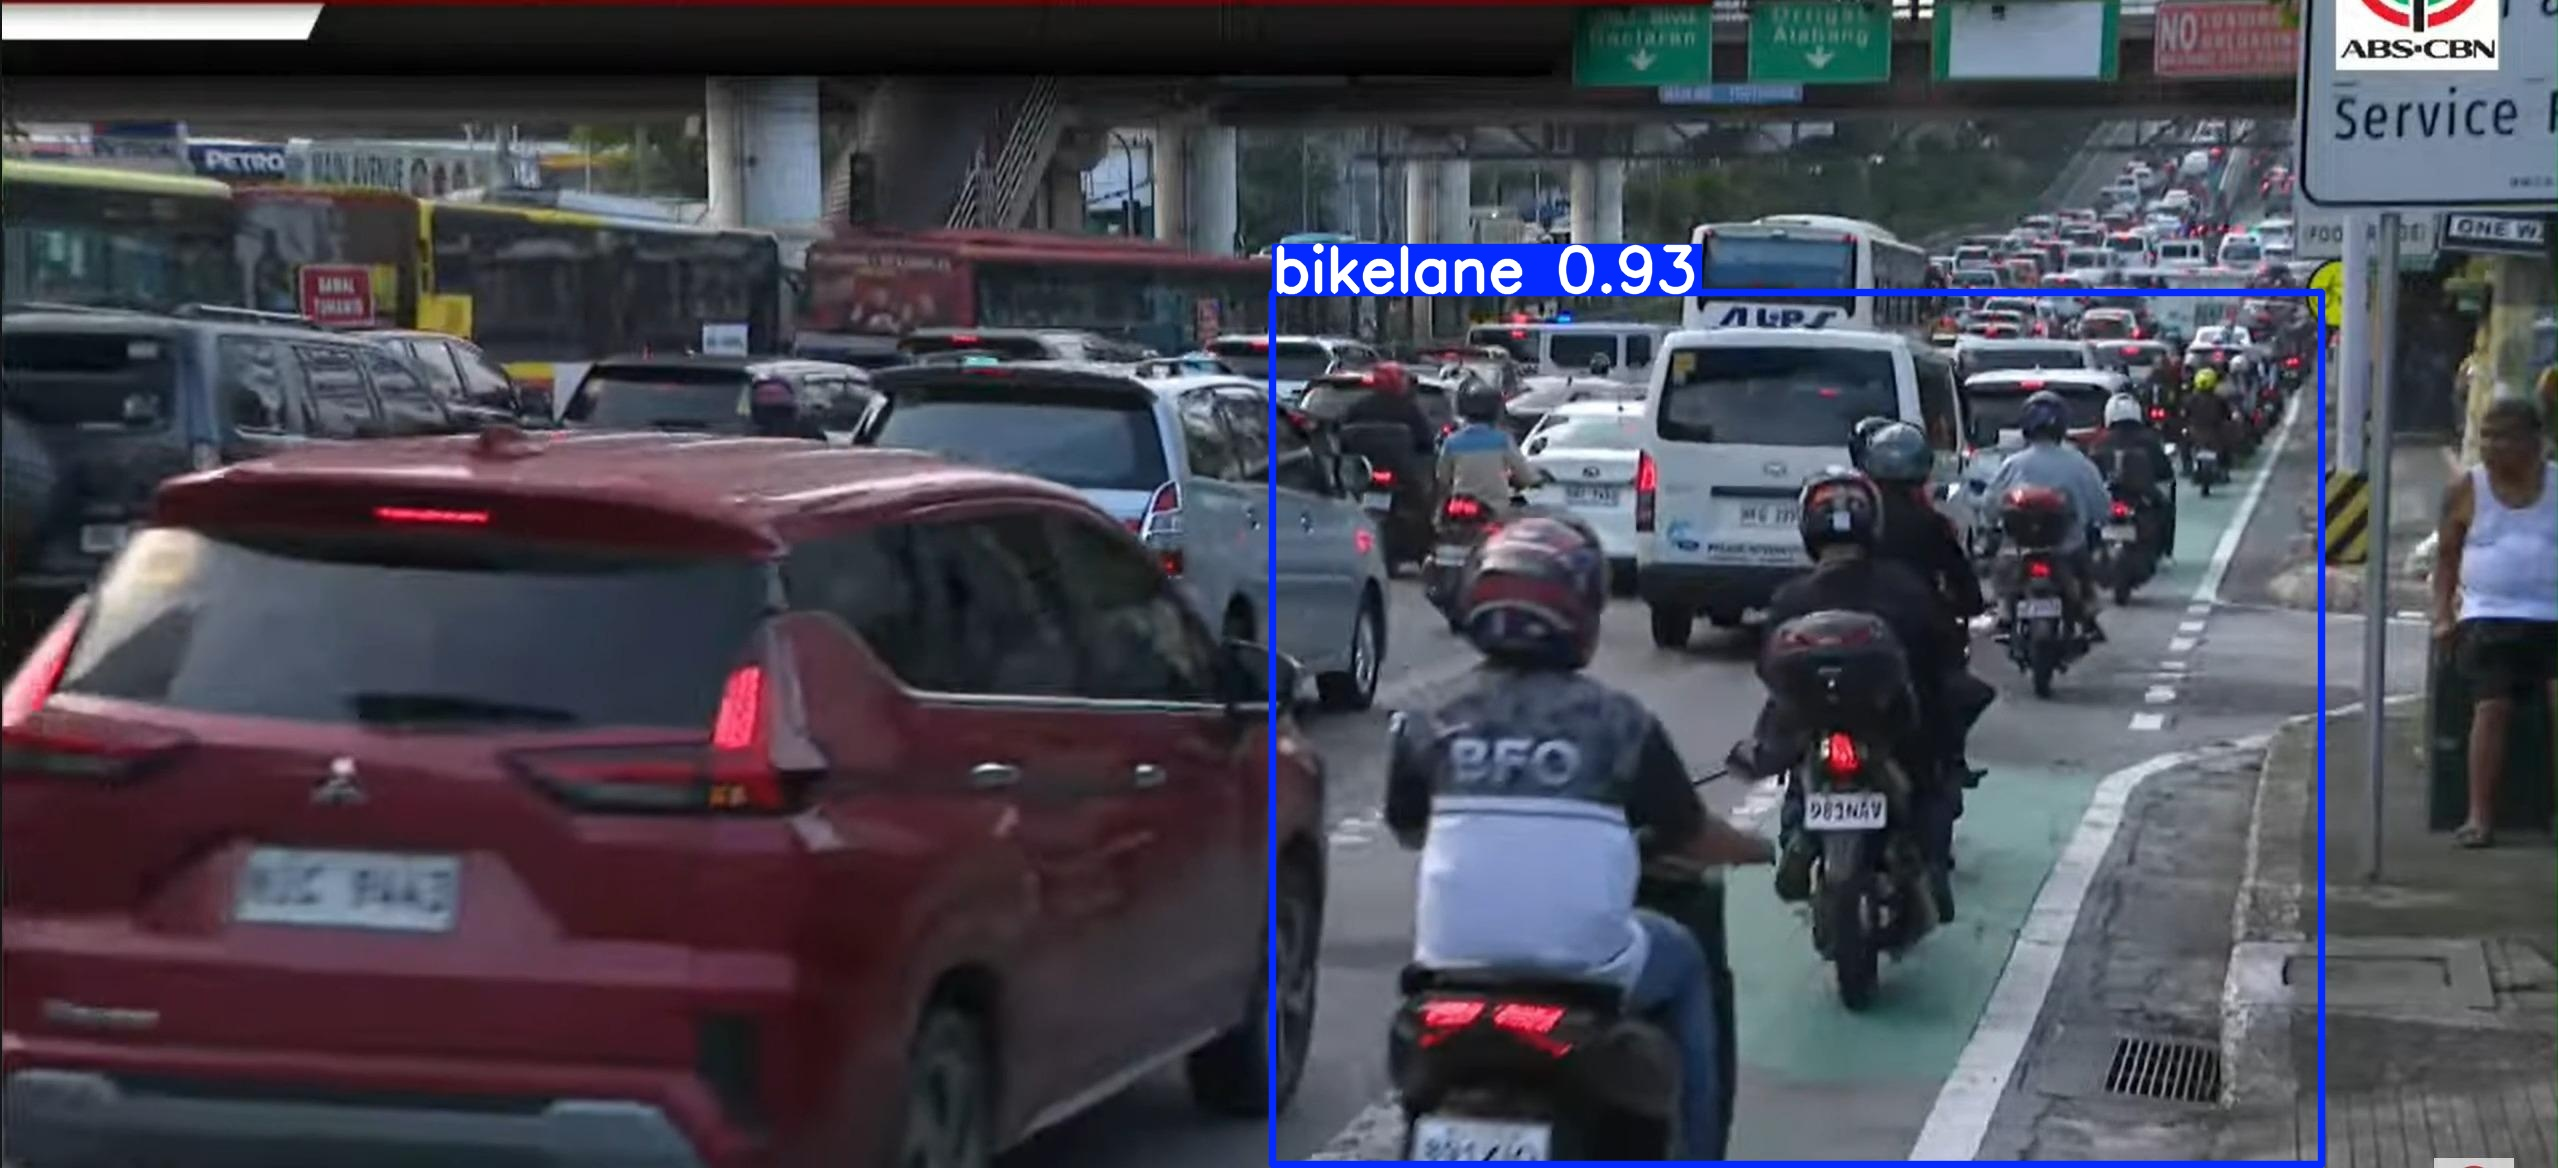

In [31]:
import os, glob, yaml, shutil

from ultralytics import YOLO

DATA_ROOT = "/content/drive/MyDrive/cvproject/Final_data"
SRC_IMG_TRAIN = f"{DATA_ROOT}/images/train"
SRC_IMG_VAL   = f"{DATA_ROOT}/images/val"
SRC_LBL_TRAIN = f"{DATA_ROOT}/labels/train"
SRC_LBL_VAL   = f"{DATA_ROOT}/labels/val"


CLASS_NAMES = [
    "bikelane"   # 0

]

assert os.path.isdir(SRC_IMG_TRAIN) and os.path.isdir(SRC_IMG_VAL), "Missing images train/val"
assert os.path.isdir(SRC_LBL_TRAIN) and os.path.isdir(SRC_LBL_VAL), "Missing labels train/val"


try:
    BIKE_ID = CLASS_NAMES.index("bikelane")
except ValueError:
    raise AssertionError("CLASS_NAMES must contain 'bikelane'")

DATA_ROOT_BIKE = DATA_ROOT + "_bikelane_only"
DST_IMG_TRAIN = f"{DATA_ROOT_BIKE}/images/train"
DST_IMG_VAL   = f"{DATA_ROOT_BIKE}/images/val"
DST_LBL_TRAIN = f"{DATA_ROOT_BIKE}/labels/train"
DST_LBL_VAL   = f"{DATA_ROOT_BIKE}/labels/val"

for d in [DST_IMG_TRAIN, DST_IMG_VAL, DST_LBL_TRAIN, DST_LBL_VAL]:
    os.makedirs(d, exist_ok=True)

def _copy_images(src_dir, dst_dir, exts=(".jpg",".jpeg",".png",".bmp",".tif",".tiff")):
    cnt = 0
    for p in glob.glob(os.path.join(src_dir, "*")):
        if p.lower().endswith(exts):
            shutil.copy2(p, os.path.join(dst_dir, os.path.basename(p)))
            cnt += 1
    return cnt

def _filter_labels(src_lbl_dir, dst_lbl_dir, bike_id):
    kept, total = 0, 0
    for lp in glob.glob(os.path.join(src_lbl_dir, "*.txt")):
        total += 1
        out_lines = []
        with open(lp, "r") as f:
            for ln in f:
                parts = ln.strip().split()
                if len(parts) >= 5:
                    try:
                        cid = int(float(parts[0]))
                    except:
                        continue
                    if cid == bike_id:
                        parts[0] = "0"
                        out_lines.append(" ".join(parts))
        outp = os.path.join(dst_lbl_dir, os.path.basename(lp))
        with open(outp, "w") as g:
            if out_lines:
                g.write("\n".join(out_lines) + "\n")
                kept += 1
            else:
                g.write("")
    return kept, total

# Copy images
n_tr = _copy_images(SRC_IMG_TRAIN, DST_IMG_TRAIN)
n_va = _copy_images(SRC_IMG_VAL,   DST_IMG_VAL)
print(f"Copied images — train: {n_tr}, val: {n_va}")

# Filter labels
k_tr, t_tr = _filter_labels(SRC_LBL_TRAIN, DST_LBL_TRAIN, BIKE_ID)
k_va, t_va = _filter_labels(SRC_LBL_VAL,   DST_LBL_VAL,   BIKE_ID)
print(f"Filtered labels — train kept: {k_tr}/{t_tr}, val kept: {k_va}/{t_va}")

# yaml
DATA_YAML = os.path.join(DATA_ROOT_BIKE, "data_bikelane_only.yaml")
with open(DATA_YAML, "w") as f:
    yaml.safe_dump({
        "train": DST_IMG_TRAIN,
        "val":   DST_IMG_VAL,
        "nc":    1,
        "names": {0: "bikelane"}
    }, f, sort_keys=False)

print("✅ Wrote", DATA_YAML)

#train
model = YOLO("yolov8s.pt")
results = model.train(
    data=DATA_YAML,
    epochs=60,
    patience=20,
    batch=16,
    imgsz=640,
    project="/content/runs",
    name="bikelane_only"
)

save_dir = str(results.save_dir)
best_pt  = os.path.join(save_dir, "weights", "best.pt")
last_pt  = os.path.join(save_dir, "weights", "last.pt")
weights  = best_pt if os.path.exists(best_pt) else last_pt
print("Using weights:", weights)

detector = YOLO(weights)
detector.model.names = {0: "bikelane"}
print("Model classes:", detector.model.names)

from IPython.display import Image as IPyImage, display
val_imgs = sorted(glob.glob(os.path.join(DST_IMG_VAL, "*.jpg")) + glob.glob(os.path.join(DST_IMG_VAL, "*.png")))
assert val_imgs, f"No images found in {DST_IMG_VAL}"
src_in_domain = val_imgs[0]
pred = detector.predict(
    source=src_in_domain,
    conf=0.15,
    save=True,
    project="/content/runs/detect",
    name="predict_val_check_bikelane_only"
)
out_dir = pred[0].save_dir
out_path = os.path.join(out_dir, os.path.basename(src_in_domain))
print("Saved:", out_path)
display(IPyImage(filename=out_path, width=900))


In [32]:
from ultralytics import YOLO
import numpy as np

obstacle_model = YOLO("yolov8n.pt")

#check for different names
def _norm(name: str) -> str:
    n = name.strip().lower().replace("-", " ").replace("_", " ")
    if n in {"bikes", "bike"}: n = "bicycle"
    if n in {"motorbike", "motorbikes"}: n = "motorcycle"
    if n in {"traffic cone", "cone"}: n = "traffic cone"
    return n

BLOCKER_NAMES = {
    "person","cyclist","bicycle","car","motorcycle","bus","truck","train","traffic light",
    "fire hydrant","stop sign","parking meter","bench","wheelchair","traffic cone"
}

# dont block these
NEVER_BLOCKER = {"bicycle", "cyclist", "motorcycle"}

def is_blocker(name: str) -> bool:
    n = _norm(name)
    return ((n in BLOCKER_NAMES) or ("cone" in n)) and (n not in NEVER_BLOCKER)

def inter_area(a, b):
    x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
    w = max(0.0, x2 - x1); h = max(0.0, y2 - y1)
    return w * h

def area(box):
    return max(0.0, (box[2]-box[0])) * max(0.0, (box[3]-box[1]))

def iou(a, b):
    inter = inter_area(a, b)
    if inter <= 0: return 0.0
    ua = area(a) + area(b) - inter
    return inter / ua if ua > 0 else 0.0

OBSTACLE_OVERLAP_FRAC = 0.50

def detect_blocking(image_path, lane_conf=0.25, obs_conf=0.35, save_vis=True,
                    project="/content/runs/detect", name="block_check"):
    # use bikelane model
    lane_pred = detector.predict(source=image_path, conf=lane_conf, save=False, verbose=False)[0]
    lane_boxes = []
    if lane_pred.boxes is not None and len(lane_pred.boxes) > 0:
        for b in lane_pred.boxes:
            cls_id = int(b.cls.item())
            raw_name = detector.names.get(cls_id, str(cls_id)) if isinstance(detector.names, dict) else detector.names[cls_id]
            cls_name = _norm(raw_name)
            if cls_name == "bikelane" or cls_id == 0:
                lane_boxes.append(b.xyxy.cpu().numpy().flatten())

    obs_pred = obstacle_model.predict(source=image_path, conf=obs_conf, save=False, verbose=False)[0]

    obstacles = []
    if obs_pred.boxes is not None and len(obs_pred.boxes) > 0:
        for b in obs_pred.boxes:
            cls_id = int(b.cls.item())
            raw = obstacle_model.names[cls_id]
            cls_name = _norm(raw)
            if (cls_name in NEVER_BLOCKER) or is_blocker(cls_name):
                obstacles.append({
                    "box": b.xyxy.cpu().numpy().flatten(),
                    "name": cls_name,  # normalized
                    "conf": float(b.conf.item()),
                    "is_cyclist": (cls_name == "cyclist")
                })

    persons = [i for i, o in enumerate(obstacles) if o["name"] == "person"]
    bikes   = [i for i, o in enumerate(obstacles) if o["name"] == "bicycle"]
    for pi in persons:
        pbox = obstacles[pi]["box"]
        for bi in bikes:
            bbox = obstacles[bi]["box"]
            if iou(pbox, bbox) >= 0.25:
                obstacles[pi]["is_cyclist"] = True
                obstacles[bi]["is_cyclist"] = True

    # check blocking
    blocking_hits = []
    for o in obstacles:
        name = o["name"]
        if (name in NEVER_BLOCKER) or o["is_cyclist"]:
            continue
        a_obs = area(o["box"])
        if a_obs <= 0:
            continue
        for lbox in lane_boxes:
            overlap = inter_area(o["box"], lbox)
            frac = overlap / a_obs
            if frac >= OBSTACLE_OVERLAP_FRAC:
                blocking_hits.append((o["box"], name, o["conf"], frac))
                break

    if save_vis:
        import cv2, os
        img = cv2.imread(image_path)
        H, W = img.shape[:2]

        # blue lanes
        for lbox in lane_boxes:
            x1,y1,x2,y2 = map(int, lbox)
            cv2.rectangle(img, (x1,y1), (x2,y2), (255,128,0), 2)
            cv2.putText(img, "bikelane", (x1, max(0,y1-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,128,0), 2)

        # green = not blocked/red = blocked/cyan for things that i dont block
        for o in obstacles:
            x1,y1,x2,y2 = map(int, o["box"])
            name = o["name"]; conf = o["conf"]
            color = (0,255,0)  # default green
            label = f"{name} {conf:.2f}"
            is_block = False
            for bh in blocking_hits:
                if np.allclose(o["box"], bh[0]):
                    color = (0,0,255)
                    label = f"{name} BLOCKING {bh[3]:.2f}"
                    is_block = True
                    break
            if not is_block and (o["name"] in NEVER_BLOCKER or o["is_cyclist"]):
                color = (255,255,0)
            cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
            cv2.putText(img, label, (x1, min(H-5, y2+18)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        os.makedirs(os.path.join(project, name), exist_ok=True)
        out_path = os.path.join(project, name, os.path.basename(image_path))
        cv2.imwrite(out_path, img)
        print("Saved vis:", out_path)
        display(IPyImage(filename=out_path, width=900))

    is_blocked = len(blocking_hits) > 0
    print(f"RESULT: {'BLOCKED' if is_blocked else 'CLEAR'}")
    if blocking_hits:
        for _, nm, cf, frac in blocking_hits:
            print(f" - {nm} conf={cf:.2f} overlap={frac:.2f}")
    return is_blocked, blocking_hits




image 1/1 /content/drive/MyDrive/cvproject/Final_data/images/val/Screenshot-2025-07-07-151423_png.rf.bbe730fdca9f463fffcdd763bbdf9fec.jpg: 480x1280 1 bikelane, 54.7ms
Speed: 5.9ms preprocess, 54.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 1280)
Results saved to /content/runs/detect/predict_val_check_bikelane_only62
Saved: /content/runs/detect/predict_val_check_bikelane_only62/Screenshot-2025-07-07-151423_png.rf.bbe730fdca9f463fffcdd763bbdf9fec.jpg


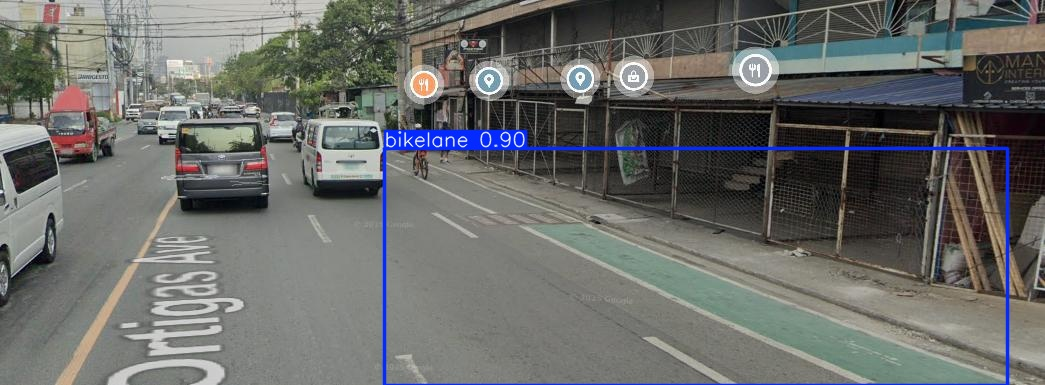

In [33]:
custom_img = "/content/drive/MyDrive/cvproject/Final_data/images/val/Screenshot-2025-07-07-151423_png.rf.bbe730fdca9f463fffcdd763bbdf9fec.jpg"
if os.path.exists(custom_img):
    pred2 = detector.predict(
        source=custom_img,
        conf=0.10,
        imgsz=1280,
        augment=True,
        save=True,
        project="/content/runs/detect",
        name="predict_val_check_bikelane_only6" #change this
        # classes=[0]
    )
    show_saved(pred2, custom_img)
else:
    print("Custom image not found:", custom_img)

In [34]:
from IPython.display import Image as IPyImage, display
import os

def show_saved(results, img_path):
    if results and results[0].save_dir:
        out_dir = results[0].save_dir
        out_path = os.path.join(out_dir, os.path.basename(img_path))
        if os.path.exists(out_path):
            print("Saved:", out_path)
            display(IPyImage(filename=out_path, width=900))
        else:
            print("Output image not found at:", out_path)
    else:
        print("No results or save directory found.")

In [51]:
test_imgs = sorted(glob.glob(os.path.join(DST_IMG_TRAIN, "*.jpg")) + glob.glob(os.path.join(DST_IMG_TRAIN, "*.png")))
sample = test_imgs[370:380]  # change to more if you want
summary = []
for p in sample:
    pred, hits = detect_blocking(p, lane_conf=0.25, obs_conf=0.35,
                                 project="/content/runs/detect", name="batch_check")
    summary.append((os.path.basename(p), pred, [(h[1], round(h[3],2)) for h in hits]))

for row in summary:
    print(row)


In [63]:
# Pick any image you want
test_img = "/content/drive/MyDrive/cvproject/Final_data/images/train/5tdh4ff5tfoa1.jpg"  # <- change this
is_blocked, hits = detect_blocking(
    test_img, lane_conf=0.25, obs_conf=0.35,
    project="/content/runs/detect", name="predict_val_check_bikelane_only6" #change prediction
)


Output hidden; open in https://colab.research.google.com to view.

In [64]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 73.5±19.8 MB/s, size: 184.6 KB)
val: Scanning /content/drive/MyDrive/cvproject/Final_data_bikelane_only/labels/val.cache... 33 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 33/33 69.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.7it/s 1.8s
                   all         33         33      0.909      0.905      0.951       0.74
Speed: 7.4ms preprocess, 9.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/runs/detect/val3


np.float64(0.9047582067749811)

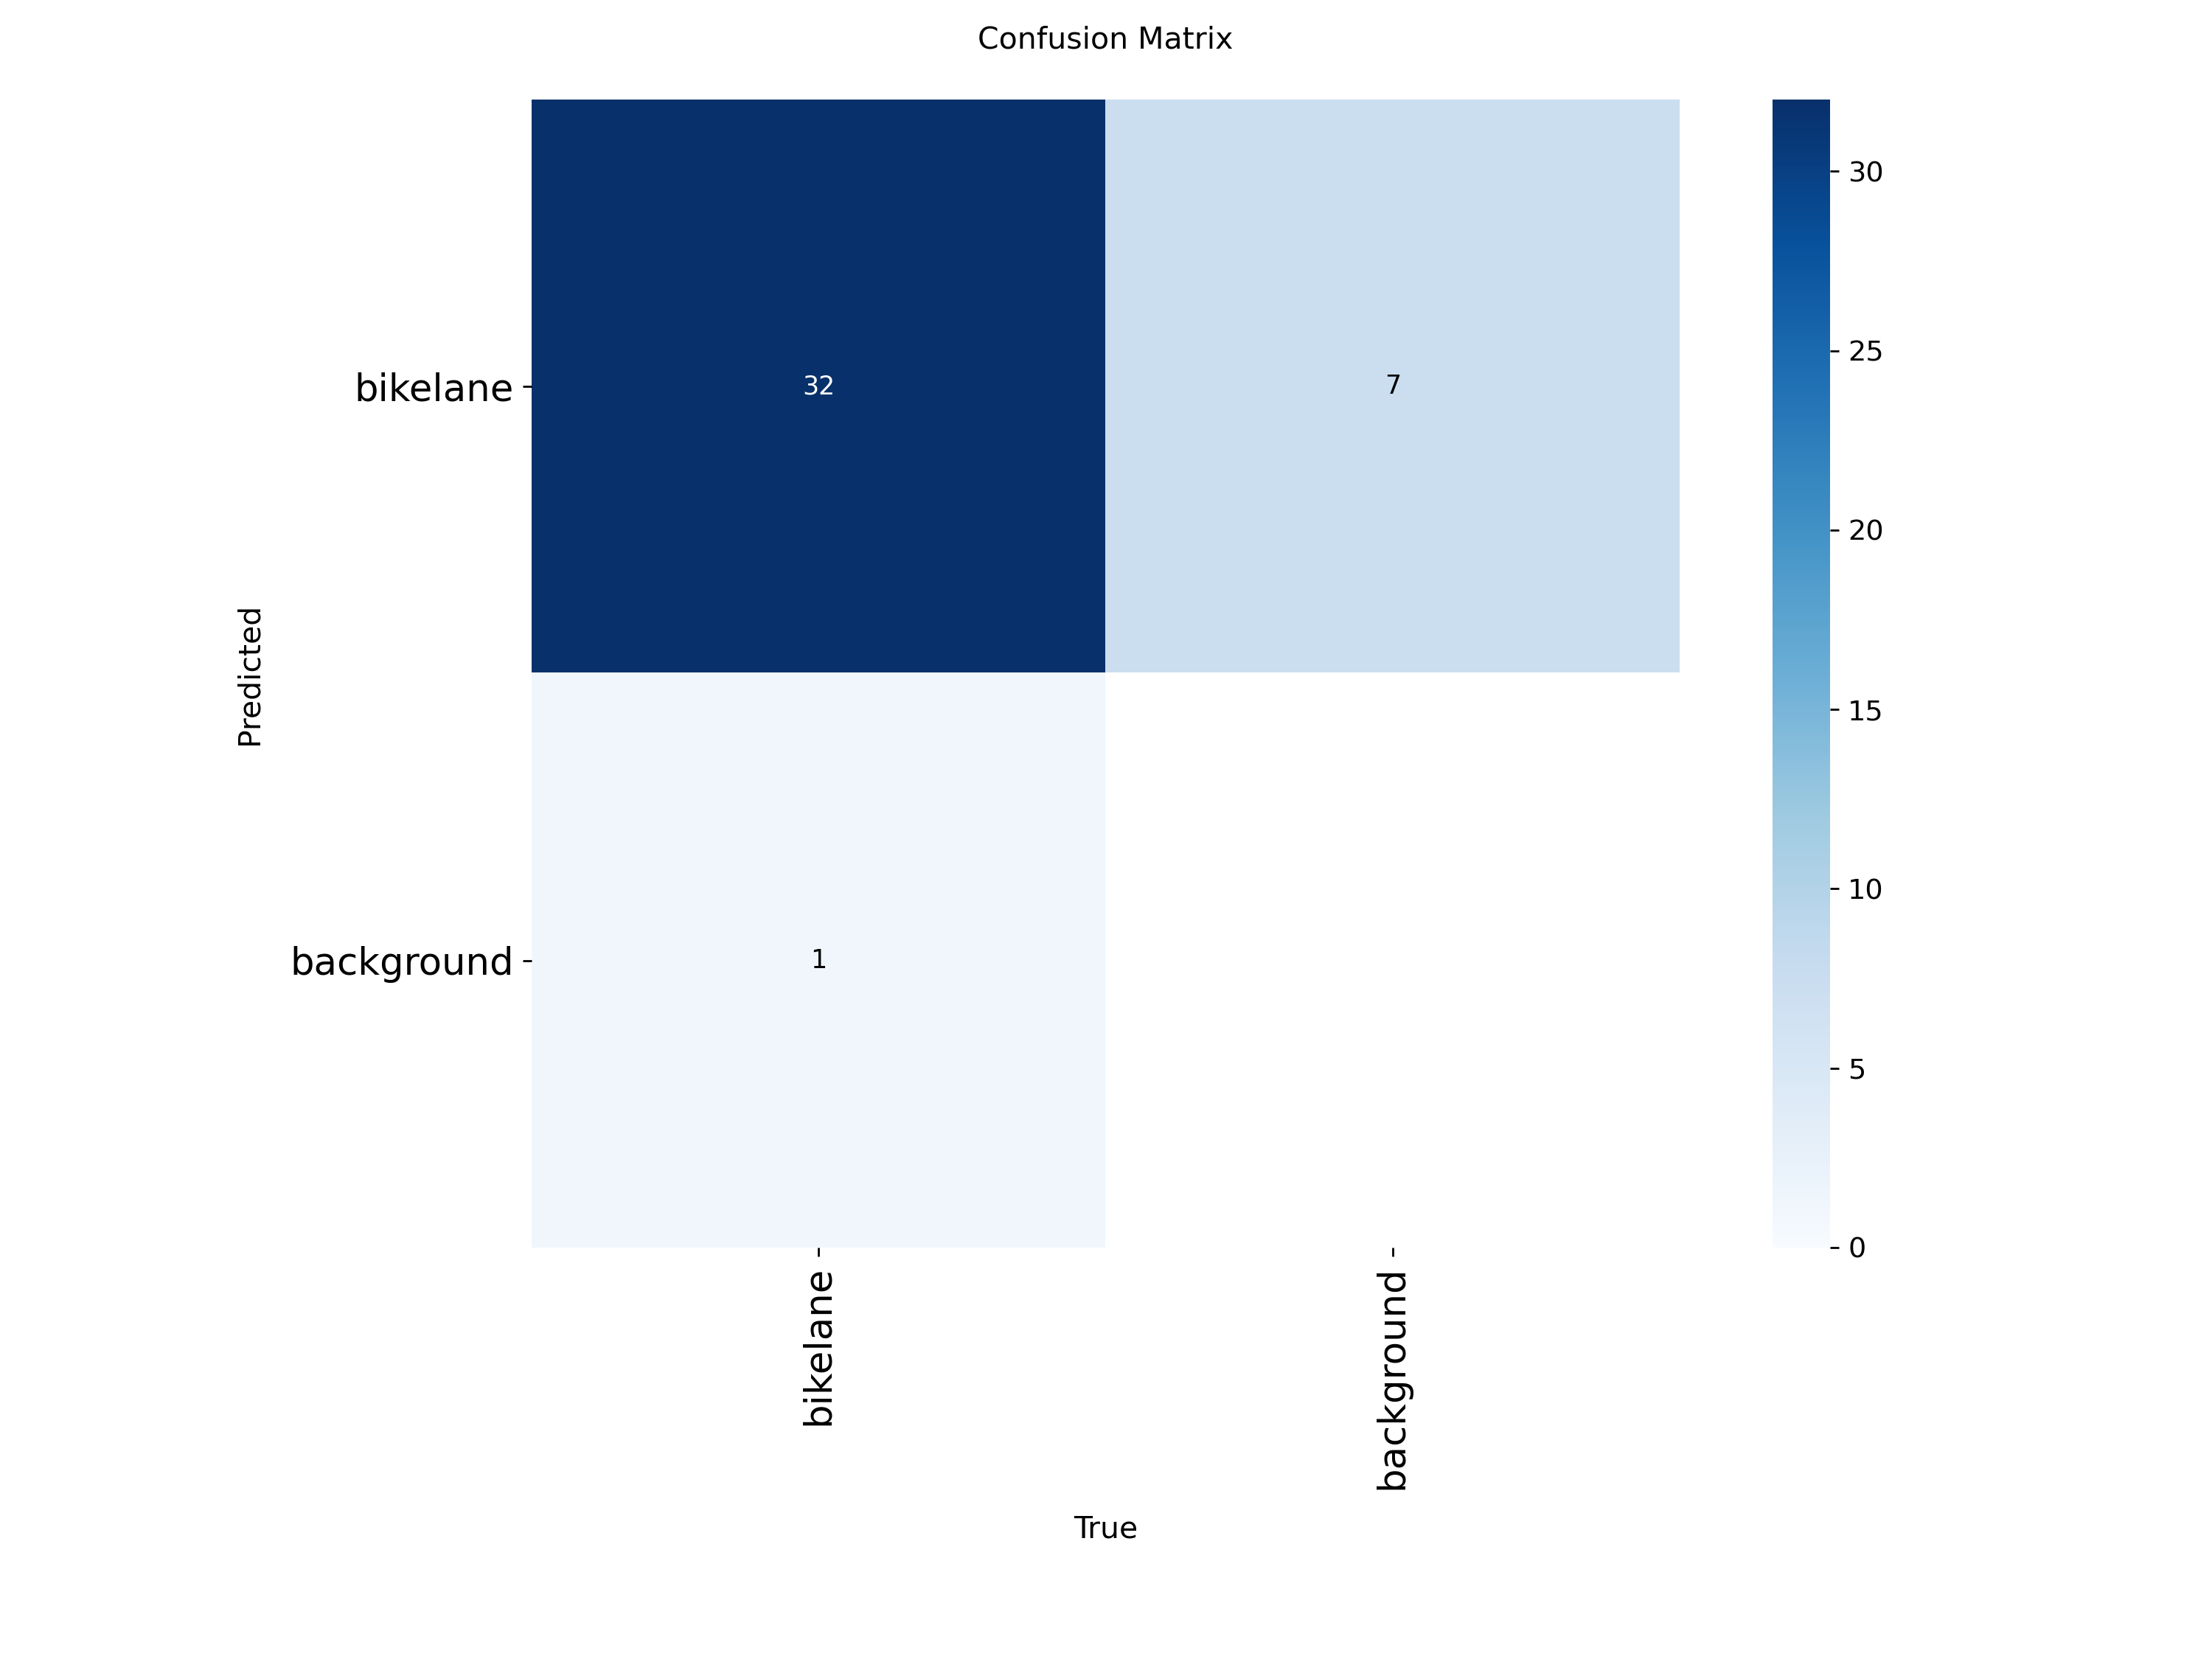

In [38]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/bikelane_only2/confusion_matrix.png')

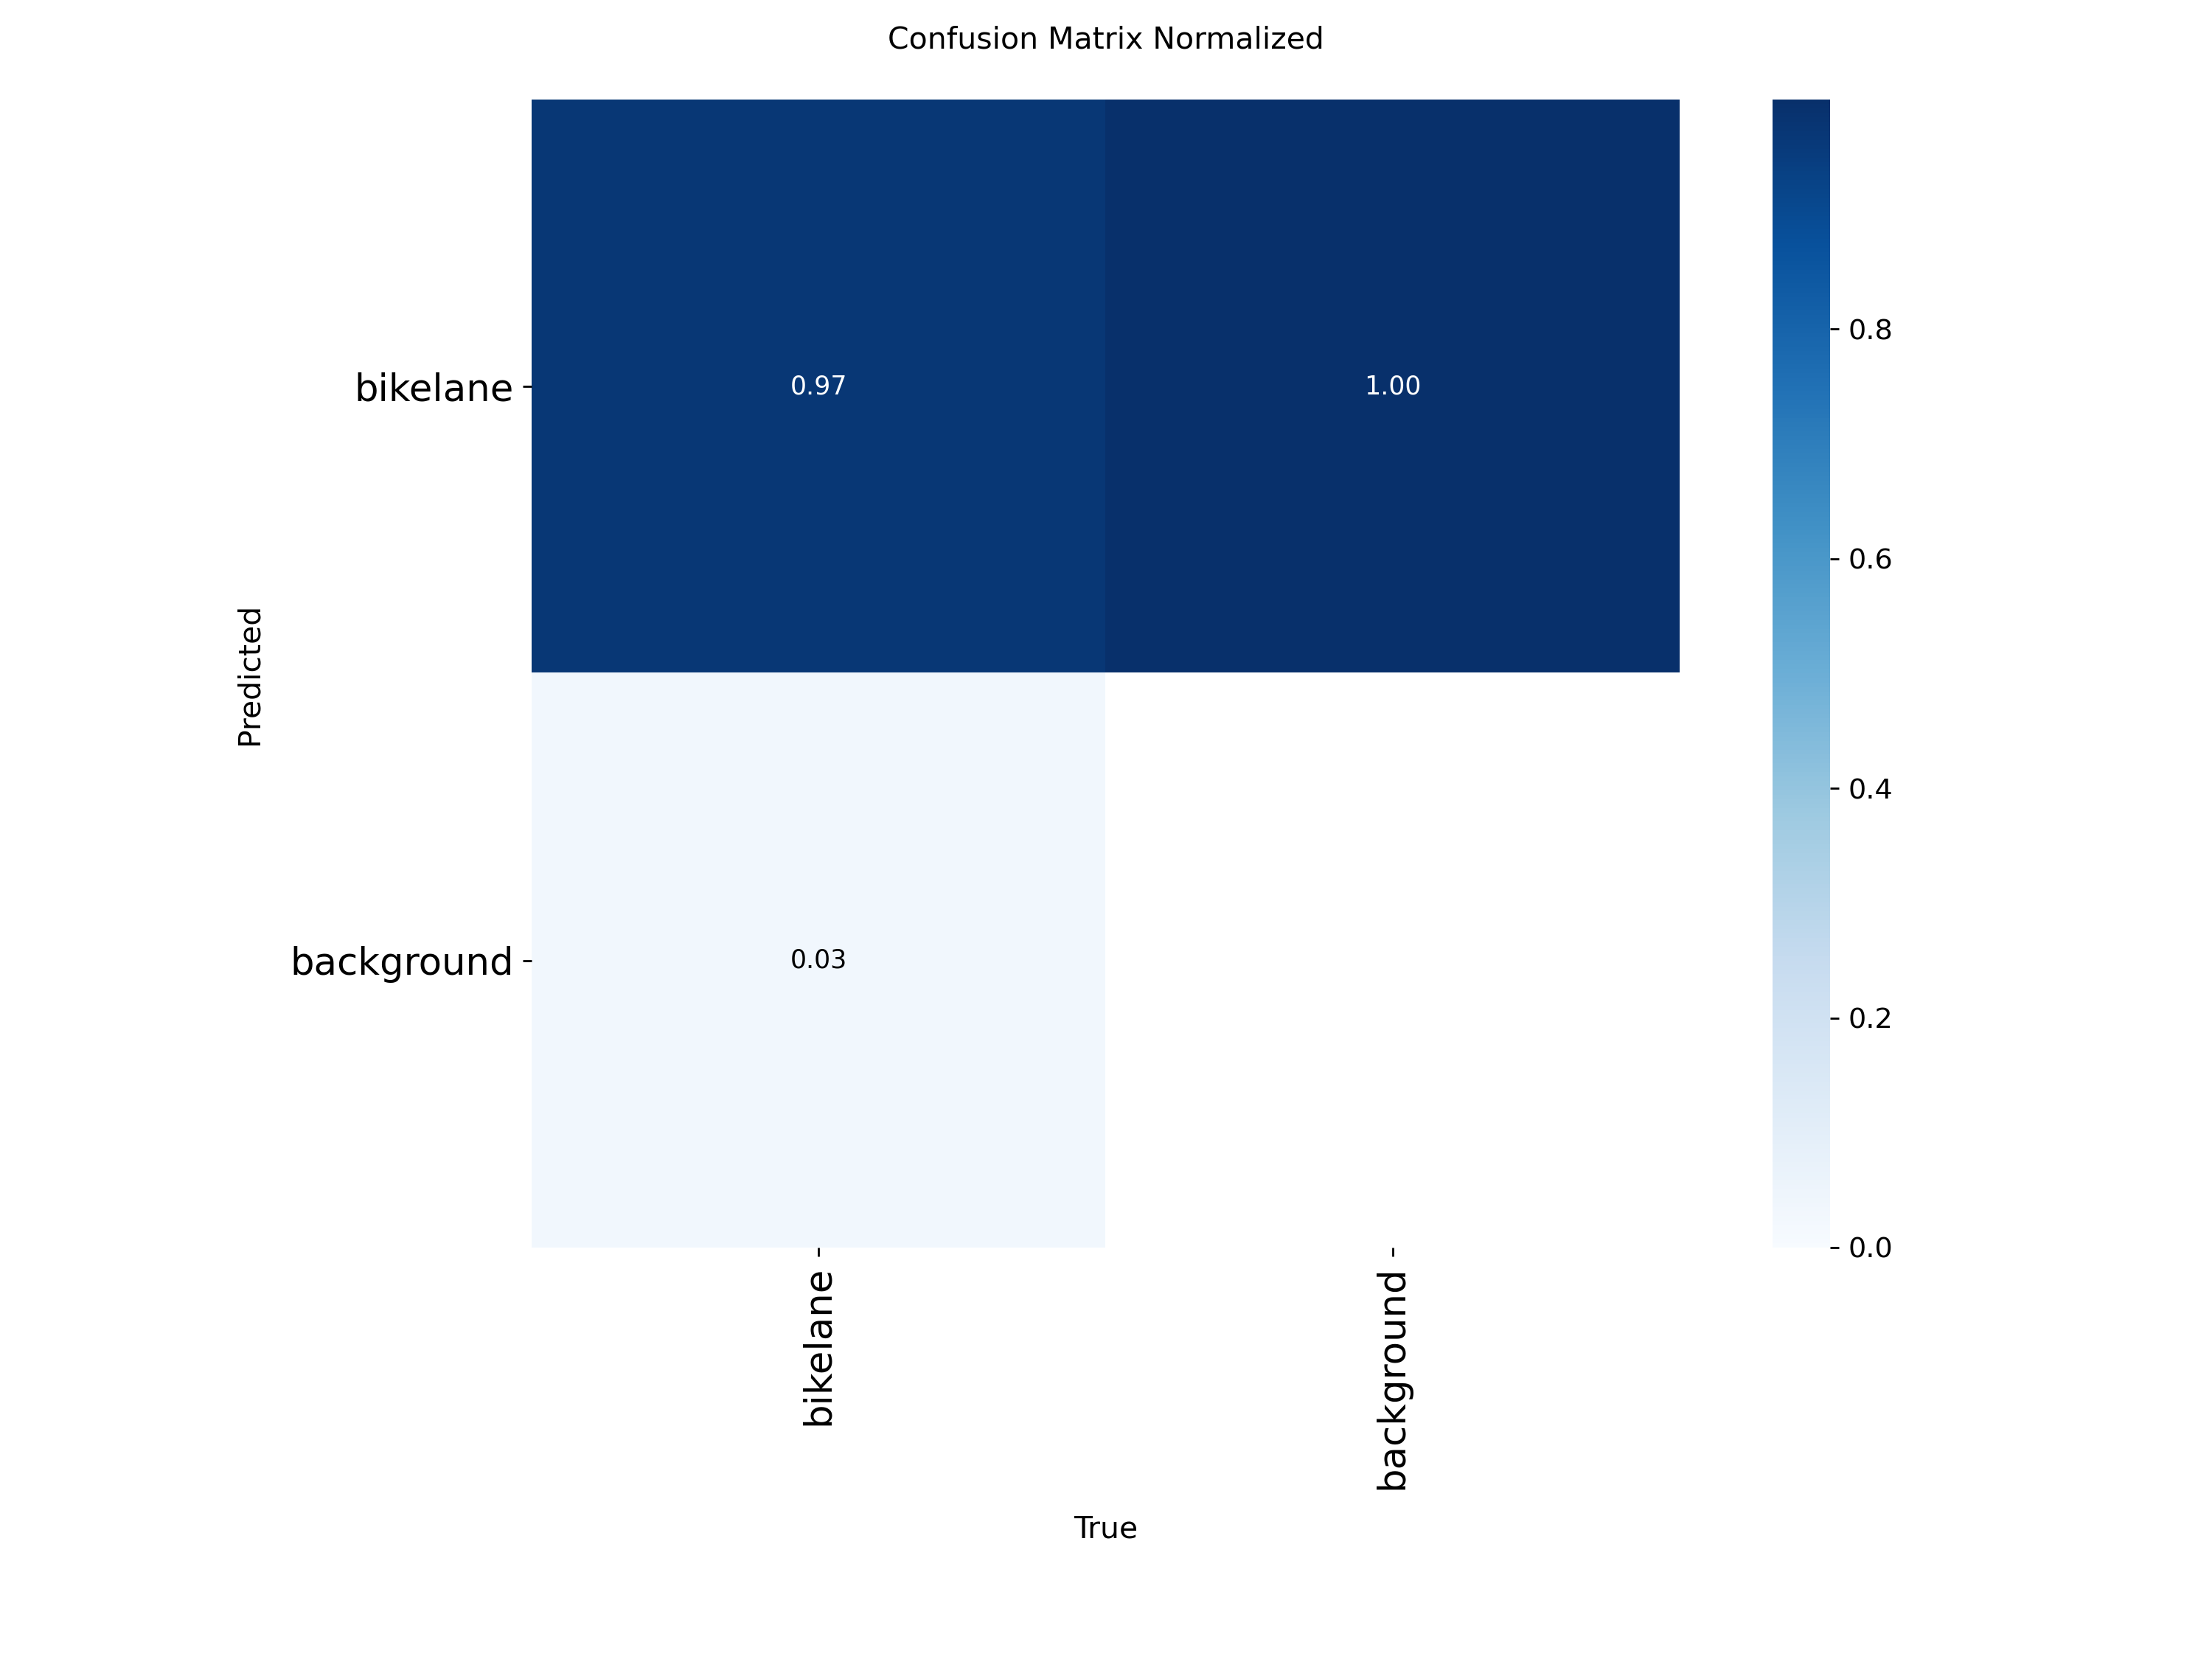

In [39]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/bikelane_only2/confusion_matrix_normalized.png')

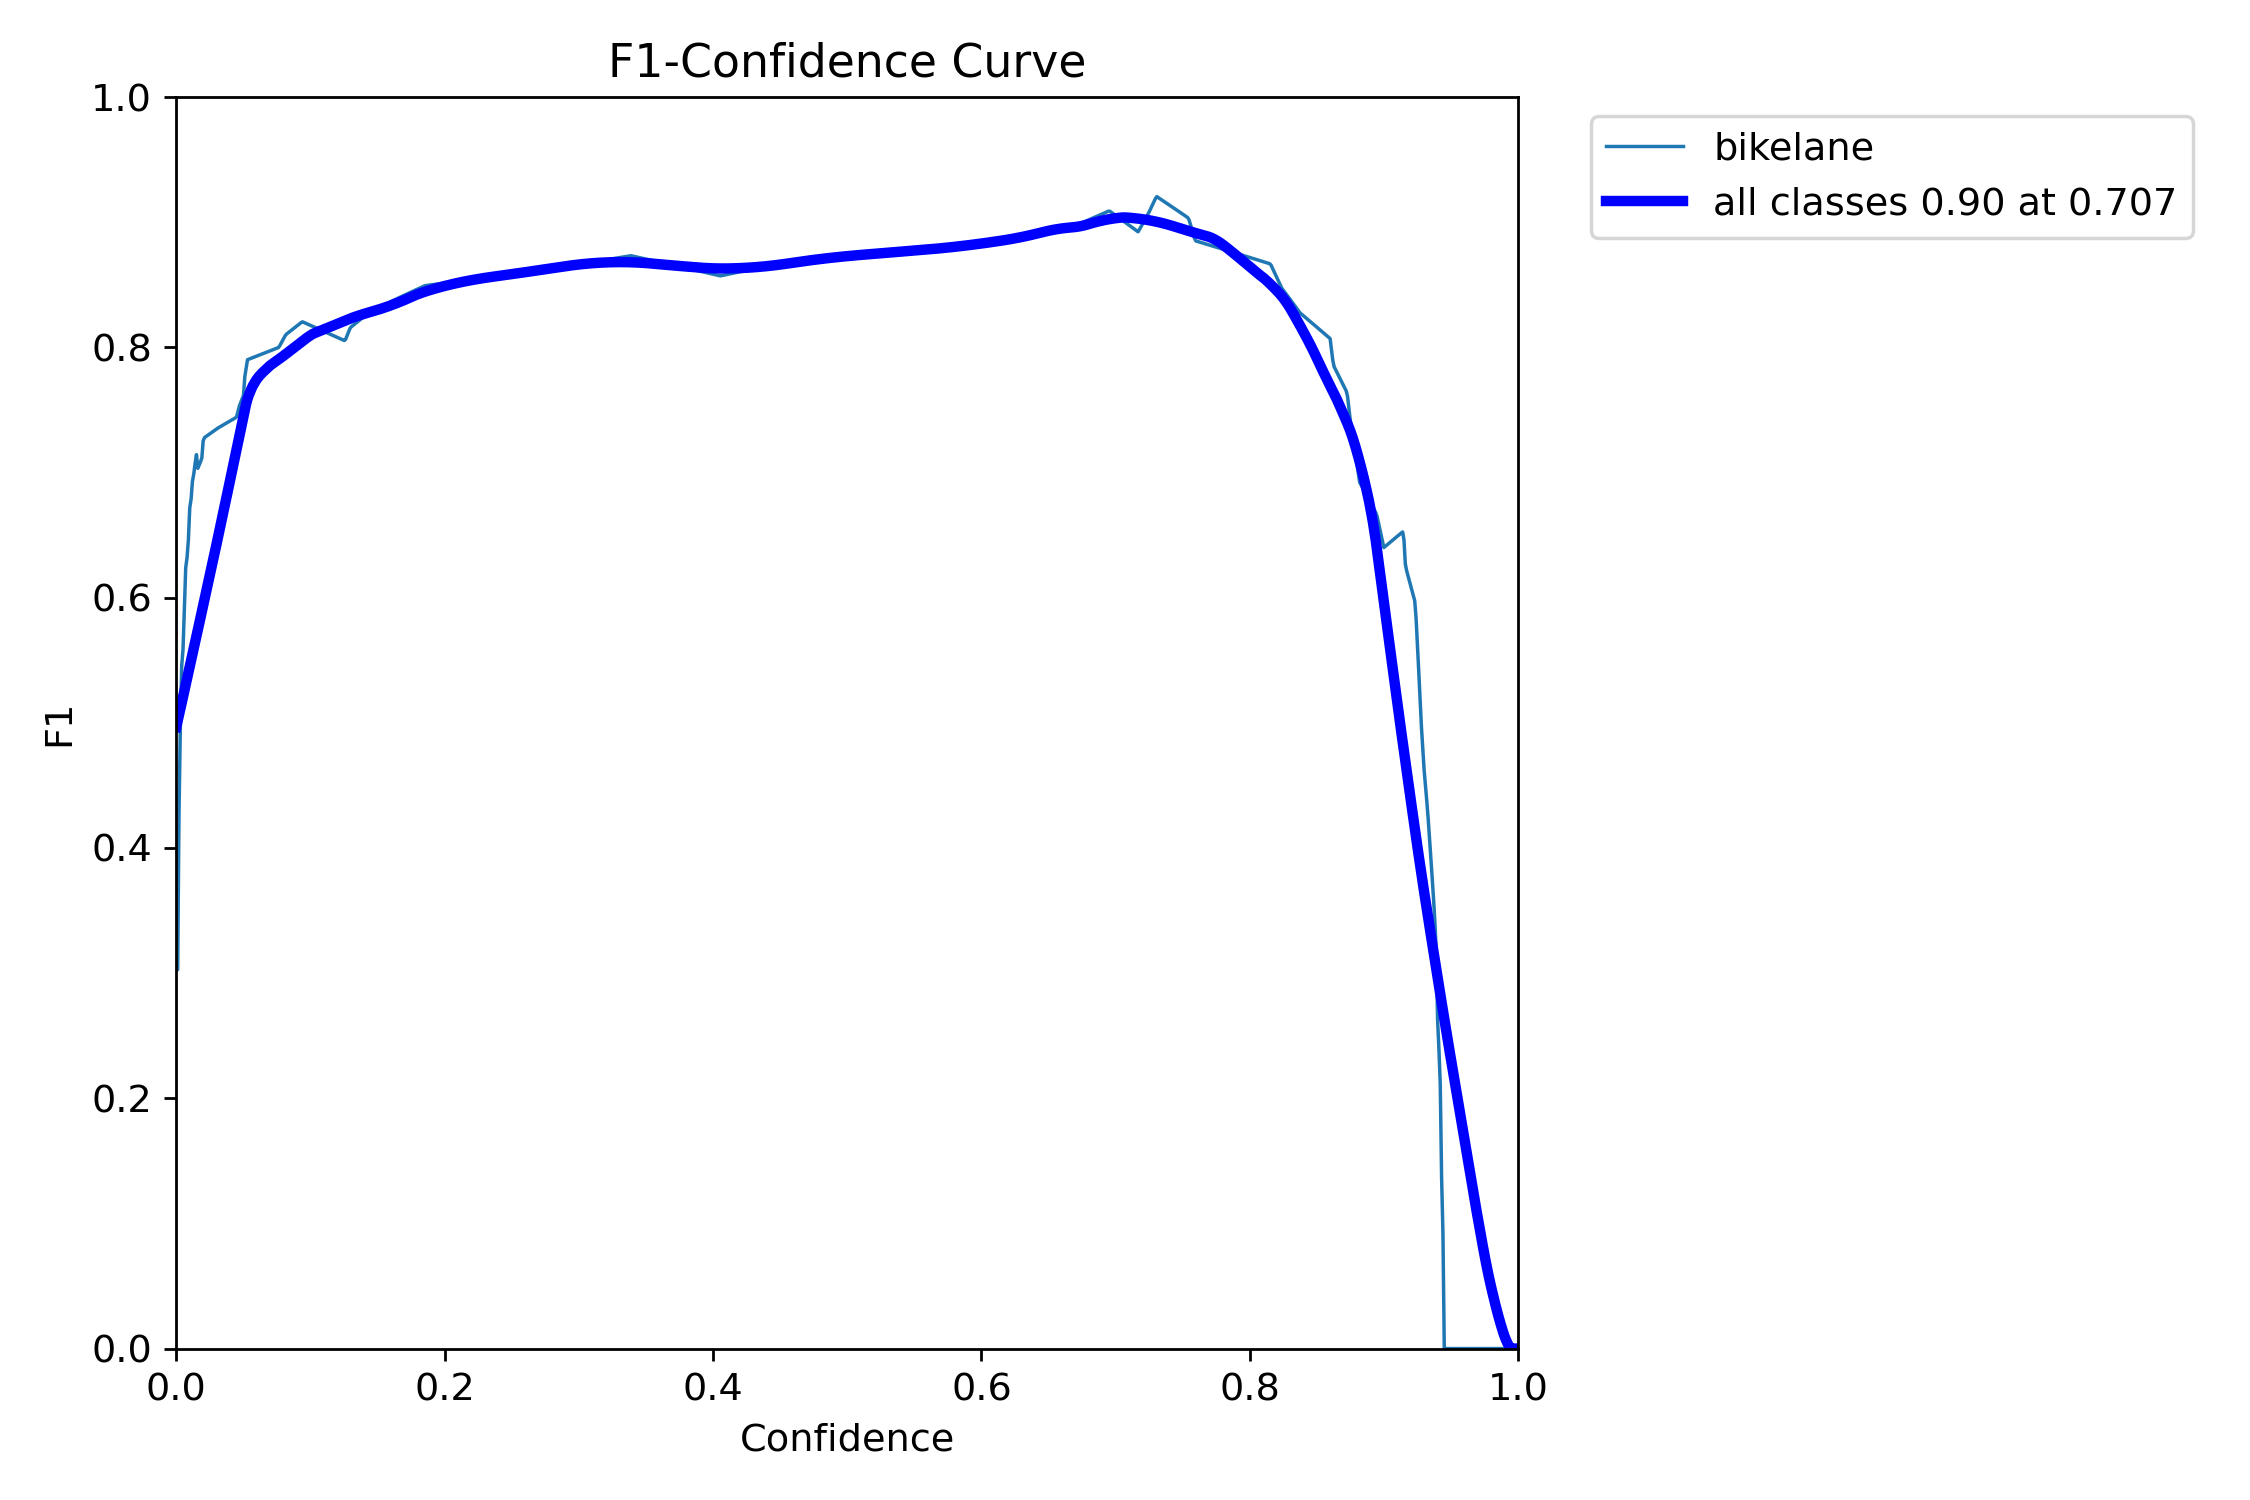

In [40]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/bikelane_only2/BoxF1_curve.png')